> __Purpose:__ This NB tests a CNN in the agglomerative model clustering procedure. With later finetuning. Uses the previously developed PyTorch code

In [1]:
model_str = "CNN"
# Train/test user split: 24/8


In [2]:
import pandas as pd
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import copy

from global_seed import set_seed
set_seed() 

from moments_engr import *
from agglo_model_clust import *
from cluster_acc_viz_funcs import *
from DNN_FT_funcs import *
from DNN_AMC_funcs import *
from model_classes import *
from full_study_funcs import *

import json
# Load the fixed user splits
with open("fixed_user_splits\\24_8_user_splits_RS17.json", "r") as f:
    splits = json.load(f)
all_participants = splits["all_users"]
test_participants = splits["test_users"]

import os
cwd = os.getcwd()
print("Current Working Directory: ", cwd)


Global seed set to 17
Current Working Directory:  c:\Users\kdmen\Repos\fl-gestures\ELEC573_Proj


In [3]:
path1 = 'C:\\Users\\kdmen\\Box\\Meta_Gesture_2024\\saved_datasets\\filtered_datasets\\$BStand_EMG_df.pkl'

with open(path1, 'rb') as file:
    raw_userdef_data_df = pickle.load(file)  # (204800, 19)

print(raw_userdef_data_df.shape)
raw_userdef_data_df.head()

(204800, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [4]:
# STEP 1: Train a classification model on every single individual user

userdef_df = raw_userdef_data_df.groupby(['Participant', 'Gesture_ID', 'Gesture_Num']).apply(create_feature_vectors)
#output is df with particpant, gesture_ID, gesture_num and feature (holds 80 len vector)
userdef_df = userdef_df.reset_index(drop=True)

#convert Gesture_ID to numerical with new Gesture_Encoded column
label_encoder = LabelEncoder()
userdef_df['Gesture_Encoded'] = label_encoder.fit_transform(userdef_df['Gesture_ID'])

label_encoder2 = LabelEncoder()
userdef_df['Cluster_ID'] = label_encoder2.fit_transform(userdef_df['Participant'])

print(userdef_df.shape)
userdef_df.head()

(3200, 6)


,Participant,Gesture_ID,Gesture_Num,feature,Gesture_Encoded,Cluster_ID
0,P004,close,1,"[[6.079045311063784], [-7.551458873254243], [-...",0,0
1,P004,close,10,"[[5.994789910363704], [-7.978871468164499], [-...",0,0
2,P004,close,2,"[[6.010193380499154], [-7.7063875553339], [-20...",0,0
3,P004,close,3,"[[5.8212078257286874], [-7.463908156909893], [...",0,0
4,P004,close,4,"[[5.974675085061773], [-7.945111601415482], [-...",0,0


In [5]:
# Some variability here wrt how the gestures are split up ig...

# Prepare data
data_splits = prepare_data(
    userdef_df, 'feature', 'Gesture_Encoded', 
    all_participants, test_participants, 
    training_trials_per_gesture=8, finetuning_trials_per_gesture=3,
)

In [6]:
features_df = pd.DataFrame(data_splits['train']['feature'])
# Create a new column 'features' that contains all 80 columns as lists
features_df['feature'] = features_df.apply(lambda row: row.tolist(), axis=1)
# Keep only the new combined column
features_df = features_df[['feature']]
# Combine with labels and participant_ids into a single DataFrame
train_df = pd.concat([features_df, pd.Series(data_splits['train']['labels'], name='Gesture_Encoded'), pd.Series(data_splits['train']['participant_ids'], name='participant_ids')], axis=1)

# TODO: Why am I fitting anotehr label_encoder? Can't I use the existing one?
#label_encoder = LabelEncoder()
train_df['Cluster_ID'] = label_encoder.fit_transform(train_df['participant_ids'])

features_df = pd.DataFrame(data_splits['intra_subject_test']['feature'])
# Create a new column 'features' that contains all 80 columns as lists
features_df['feature'] = features_df.apply(lambda row: row.tolist(), axis=1)
# Keep only the new combined column
features_df = features_df[['feature']]
# Combine with labels and participant_ids into a single DataFrame
test_df = pd.concat([features_df, pd.Series(data_splits['intra_subject_test']['labels'], name='Gesture_Encoded'), pd.Series(data_splits['intra_subject_test']['participant_ids'], name='participant_ids')], axis=1)

# TODO: Why am I fitting anotehr label_encoder? Can't I use the existing one?
#label_encoder = LabelEncoder()
test_df['Cluster_ID'] = label_encoder.fit_transform(test_df['participant_ids'])

# ENTIRELY WITHHOLDING CROSS CLUSTER DATASET (NOVEL TEST SUBJECTS) FOR NOW. 
#test_df
#features_df = pd.DataFrame(data_splits['train']['features'])
## Create a new column 'features' that contains all 80 columns as lists
#features_df['features'] = features_df.apply(lambda row: row.tolist(), axis=1)
## Keep only the new combined column
#features_df = features_df[['features']]
## Combine with labels and participant_ids into a single DataFrame
#train_df = pd.concat([features_df, pd.Series(data_splits['train']['labels'], name='Gesture_Encoded'), pd.Series(data_splits['train']['participant_ids'], name='participant_ids')], axis=1)

In [7]:
data_dfs_dict = {'train':train_df, 'test':test_df}

# Need to update Cluster_ID col at the end of each round, for both dfs

In [8]:
train_df.head()

,feature,Gesture_Encoded,participant_ids,Cluster_ID
0,"[-0.44668966520171266, -2.245376314770396, -2....",0,P008,3
1,"[-0.6165955435593868, -0.9916341572882518, -0....",0,P008,3
2,"[-1.103820832412997, -0.4688808244790105, 1.12...",0,P008,3
3,"[0.3763026411180301, -2.4207295055050264, -4.1...",0,P008,3
4,"[0.6010777470052335, -1.8335314075536508, -3.6...",0,P008,3


In [9]:
# OOF this was already redoing it each time from scratch... didn't really need to save then...
## There's no way the cluster set is messed up then

# n_splits is crossval... how does that combine with my user split??
## Verify how it is doing its split, it was using stratified cross val but it doesnt need to be doing that...
## Saves only the first fold's models
## Well it should only be doing crossval on passed in training set of 24 anyways?

#merge_log, intra_cluster_performance, cross_cluster_performance, nested_clus_model_dict = DNN_agglo_merge_procedure(data_dfs_dict, model_str, n_splits=1)

In [10]:
# Replacing the above with saved results so it doesn't have to reload every time

# Load the CLUSTERING RESULTS DATA
with open('C:\\Users\\kdmen\\Repos\\fl-gestures\\ELEC573_Proj\\results\\clustering_models\\20250219_1649_CNN_agglo_merge_res.pkl', 'rb') as f:
    merge_log = pickle.load(f)
    intra_cluster_performance = pickle.load(f)
    cross_cluster_performance = pickle.load(f)
    nested_clus_model_dict = pickle.load(f)

print("Data has been loaded successfully!")

Data has been loaded successfully!


In [11]:
merge_log

[(0, 0, 10, 0.35, 24),
 (1, 1, 8, 0.35, 25),
 (2, 2, 25, 0.35, 26),
 (3, 19, 23, 0.35, 27),
 (4, 20, 15, 0.3, 28),
 (5, 26, 16, 0.3, 29),
 (6, 6, 12, 0.3, 30),
 (7, 17, 7, 0.25, 31),
 (8, 30, 13, 0.3, 32),
 (9, 32, 9, 0.3, 33),
 (10, 27, 4, 0.25, 34),
 (11, 18, 24, 0.225, 35),
 (12, 34, 29, 0.275, 36),
 (13, 5, 21, 0.2, 37),
 (14, 28, 3, 0.25, 38),
 (15, 31, 22, 0.2, 39),
 (16, 11, 14, 0.2, 40),
 (17, 35, 33, 0.175, 41),
 (18, 37, 40, 0.15, 42),
 (19, 38, 36, 0.17857142857142858, 43),
 (20, 42, 39, 0.11666666666666667, 44),
 (21, 41, 43, 0.115, 45),
 (22, 44, 45, 0.09705882352941177, 46)]

# Finetuning Process

In [12]:
cluster_lst = list(nested_clus_model_dict['Iter18'].keys())
print("Cluster list:")
print(cluster_lst)
print()
print("Cluster 41 model:")
print(nested_clus_model_dict['Iter18'][41])

Cluster list:
[36, 37, 38, 39, 40, 41]

Cluster 41 model:
CNNModel(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): Identity()
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): Identity()
  (fc1): Linear(in_features=1280, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [13]:
# EVALUATION

# I would need to 
## 1) know which pids are in each cluster, at each merge iteration, 
## 2) bissect the datasets accordingly, 
## 3) create the trainloaders

# And idk from which merge iteration I would report the results from...
## Obv wouldnt want to show 30 iterations x 2-30 clusters per iter...

In [14]:
# WANT TO COMPARE THE MODEL PERFORMANCE ON THE NOVEL CLIENT PRE AND POST FT
## VARY AMOUNT OF FT: 
## 1) hyperparams (epoch, lr, weight decay, dropout, etc) and 
## 2) how much data from novel_trainFT is used

## Formalizing Procedure Into a Function

In [15]:
# BEST PARAMS FOR GENERIC MODEL
#lr=0.0001, bs=32, num_ep=50, adam, wd=0.0001, dr=0.3, num_conv=3, 32/64/128, k=5, s=2, m=1, bn=True
config = {
    "learning_rate": 0.0001,
    "batch_size": 32,
    "num_epochs": 50,
    "optimizer": "adam",
    "weight_decay": 1e-4,
    "dropout_rate": 0.3,
    "num_conv_layers": 3,
    "conv_layer_sizes": [32, 64, 128], 
    "kernel_size": 5,
    "stride": 2,
    "padding": 1,
    "maxpool": 1,
    "use_batchnorm": True
}

#full_path = os.path.join(cwd, 'ELEC573_Proj', 'models', 'generic_CNN_model.pth')
full_path = os.path.join(cwd, 'models', 'user_split_RS17_generic_CNN_model.pth')
print("Full Path:", full_path)

# Load the pretrained model
pretrained_generic_CNN_model = CNNModel_3layer(config, input_dim=80, num_classes=10)
pretrained_generic_CNN_model.load_state_dict(torch.load(full_path))

Full Path: c:\Users\kdmen\Repos\fl-gestures\ELEC573_Proj\models\user_split_RS17_generic_CNN_model.pth


<All keys matched successfully>

In [16]:
cluster_lst = list(nested_clus_model_dict['Iter18'].keys())
print("Cluster list:")
print(cluster_lst)
print()
print("Cluster 41 model:")
print(nested_clus_model_dict['Iter18'][41])

Cluster list:
[36, 37, 38, 39, 40, 41]

Cluster 41 model:
CNNModel(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): Identity()
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): Identity()
  (fc1): Linear(in_features=1280, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [17]:
# Prepare data
one_trial_data_splits = prepare_data(
    userdef_df, 'feature', 'Gesture_Encoded', 
    all_participants, test_participants, 
    training_trials_per_gesture=1, finetuning_trials_per_gesture=1,
)

five_trial_data_splits = prepare_data(
    userdef_df, 'feature', 'Gesture_Encoded', 
    all_participants, test_participants, 
    training_trials_per_gesture=5, finetuning_trials_per_gesture=5,
)

## 5 trials for training (local+FT)

In [18]:
train_pids = np.unique(five_trial_data_splits['train']['participant_ids'])
novel_participant_ft_data = five_trial_data_splits['novel_trainFT']
novel_participant_test_data = five_trial_data_splits['cross_subject_test']
novel_pids = np.unique(five_trial_data_splits['novel_trainFT']['participant_ids'])
num_local_training_epochs = 50
num_ft_epochs = 50
ft_lr = 0.001
novel_pid_clus_asgn_data = five_trial_data_splits['novel_trainFT']

novel_pid_res_dict = {}

for pid_count, pid in enumerate(novel_pids):
    print(f"PID {pid}, {pid_count}/{len(novel_pids)}")
    novel_pid_res_dict[pid] = {}

    # Create the testloader by segmenting out this specific pid
    # Filter based on participant_id
    indices = [i for i, datasplit_pid in enumerate(novel_participant_ft_data['participant_ids']) if datasplit_pid == pid]
    ############## Novel Participant Finetuning Dataset ##############
    ft_dataset = GestureDataset([novel_participant_ft_data['feature'][i] for i in indices], [novel_participant_ft_data['labels'][i] for i in indices])
    ft_loader = DataLoader(ft_dataset, batch_size=config["batch_size"], shuffle=True)
    ############## Novel Participant Intra Testing Dataset ##############
    indices = [i for i, datasplit_pid in enumerate(novel_participant_test_data['participant_ids']) if datasplit_pid == pid]
    intra_test_dataset = GestureDataset([novel_participant_test_data['feature'][i] for i in indices], [novel_participant_test_data['labels'][i] for i in indices])
    intra_test_loader = DataLoader(intra_test_dataset, batch_size=config["batch_size"], shuffle=True)
    ############## Novel Participant Cross Testing Dataset ##############
    indices = [i for i, datasplit_pid in enumerate(novel_participant_test_data['participant_ids']) if datasplit_pid != pid]
    cross_test_dataset = GestureDataset([novel_participant_test_data['feature'][i] for i in indices], [novel_participant_test_data['labels'][i] for i in indices])
    cross_test_loader = DataLoader(cross_test_dataset, batch_size=config["batch_size"], shuffle=True)
    ############## One Trial Cluster Assignment Dataset ##############
    indices = [i for i, datasplit_pid in enumerate(novel_pid_clus_asgn_data['participant_ids']) if datasplit_pid == pid]
    clust_asgn_dataset = GestureDataset([novel_pid_clus_asgn_data['feature'][i] for i in indices], [novel_pid_clus_asgn_data['labels'][i] for i in indices])
    clust_asgn_loader = DataLoader(clust_asgn_dataset, batch_size=config["batch_size"], shuffle=True)

    # 1) Train a local CNN model
    local_model = CNNModel_3layer(config, input_dim=80, num_classes=10)
    local_results = main_training_pipeline(data_splits=None, train_intra_cross_loaders=[ft_loader, intra_test_loader, cross_test_loader],
                        all_participants=train_pids, test_participants=novel_pids, model_type=local_model,  
                        num_epochs=num_local_training_epochs, config=config)
    # This is kind of repeated but whatever
    local_clus_res = evaluate_model(local_model, intra_test_loader)
    novel_pid_res_dict[pid]["local_acc"] = local_clus_res["accuracy"]

    # 1.5) Test the pretrained GENERIC (e.g. not cluster-level) model
    generic_clus_res = evaluate_model(pretrained_generic_CNN_model, intra_test_loader)
    novel_pid_res_dict[pid]["generic_acc"] = generic_clus_res["accuracy"]

    # 2) Have the pretrained CNN model from the best cluster do inference
    #   - Have all cluster models do inference and compare assign to whichever cluster gives best results
    #pretrained_generic_CNN_model
    # Apply all the cluster models at the chosen iteration on the given participant data
    ## Record that cluster's performance (all cluster's performances?... Ideally)
    clus_model_res_dict = {}
    for clus_id in cluster_lst:
        clus_model = nested_clus_model_dict['Iter18'][clus_id]
        clus_res = evaluate_model(clus_model, clust_asgn_loader) 
        clus_acc = clus_res["accuracy"]
        clus_model_res_dict[clus_id] = clus_acc
    # Assign participant to highest scoring cluster
    # Find the key with the highest accuracy
    max_key = max(clus_model_res_dict, key=clus_model_res_dict.get)
    max_value = clus_model_res_dict[max_key]
    print(f"The highest accuracy is {max_value} and it is associated with the key {max_key}.")
    print("Full cluster assignment results dict:")
    print(clus_model_res_dict)
    original_cluster_model = nested_clus_model_dict['Iter18'][max_key]
    # Have the pretrained CNN model from the best cluster do inference
    pretrained_clus_res = evaluate_model(original_cluster_model, intra_test_loader)
    novel_pid_res_dict[pid]["pretrained_acc"] = pretrained_clus_res["accuracy"]

    # 3) FT the above model (or all??) pretrained CNN model on the participant
    ft_model, _, train_loss_log, test_loss_log = fine_tune_model(
        copy.deepcopy(original_cluster_model), ft_loader, intra_test_loader, num_epochs=num_ft_epochs, lr=ft_lr)
    ft_clus_res = evaluate_model(ft_model, intra_test_loader)
    novel_pid_res_dict[pid]["ft_acc"] = ft_clus_res["accuracy"]


PID P010, 0/8


c:\Users\kdmen\Repos\fl-gestures\ELEC573_Proj\DNN_FT_funcs.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  self.features = torch.tensor(features, dtype=torch.float32)


The highest accuracy is 0.14 and it is associated with the key 41.
Full cluster assignment results dict:
{36: 0.12, 37: 0.1, 38: 0.1, 39: 0.1, 40: 0.12, 41: 0.14}
PID P103, 1/8
The highest accuracy is 0.3 and it is associated with the key 37.
Full cluster assignment results dict:
{36: 0.1, 37: 0.3, 38: 0.1, 39: 0.08, 40: 0.2, 41: 0.02}
PID P104, 2/8
The highest accuracy is 0.14 and it is associated with the key 37.
Full cluster assignment results dict:
{36: 0.12, 37: 0.14, 38: 0.06, 39: 0.04, 40: 0.06, 41: 0.08}
PID P108, 3/8
The highest accuracy is 0.18 and it is associated with the key 37.
Full cluster assignment results dict:
{36: 0.02, 37: 0.18, 38: 0.14, 39: 0.1, 40: 0.02, 41: 0.04}
PID P116, 4/8
The highest accuracy is 0.28 and it is associated with the key 37.
Full cluster assignment results dict:
{36: 0.04, 37: 0.28, 38: 0.06, 39: 0.2, 40: 0.0, 41: 0.1}
PID P125, 5/8
The highest accuracy is 0.24 and it is associated with the key 37.
Full cluster assignment results dict:
{36: 0.

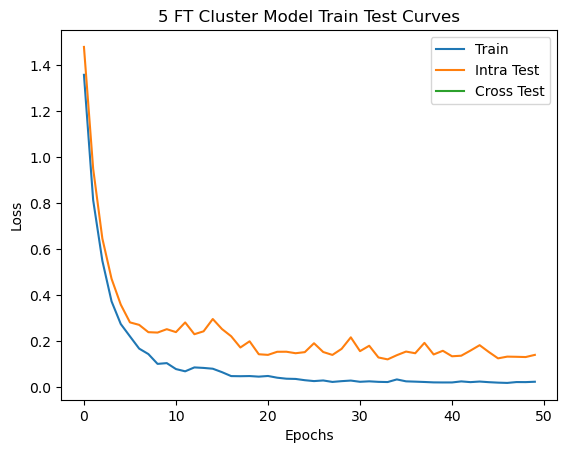

In [19]:
res_dict = {"train_loss_log": train_loss_log, "intra_test_loss_log":test_loss_log, "cross_test_loss_log":[]}
plot_train_test_curves(res_dict, "5 FT Cluster Model Train Test Curves", print_acc=False, acc_keys=None, log_keys=None)

In [20]:
local_acc_data = [] 
pretrained_acc_data = [] 
ft_acc_data = [] 
generic_acc_data = []
# Collecting data from the dictionary 
for pid in novel_pid_res_dict: 
    local_acc_data.append(novel_pid_res_dict[pid]['local_acc']) 
    pretrained_acc_data.append(novel_pid_res_dict[pid]['pretrained_acc']) 
    ft_acc_data.append(novel_pid_res_dict[pid]['ft_acc']) 
    generic_acc_data.append(novel_pid_res_dict[pid]['generic_acc']) 

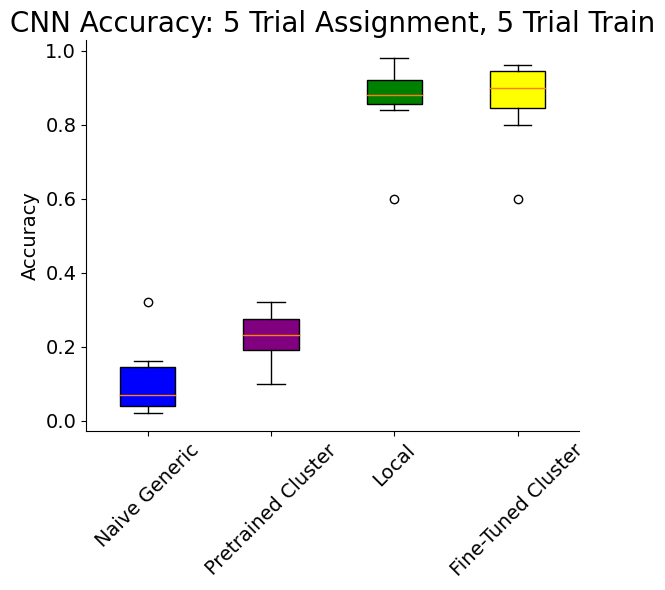

In [21]:
# Plotting box plots with improved aesthetics 
fig, ax = plt.subplots(figsize=(6, 6)) 
data = [generic_acc_data, pretrained_acc_data, local_acc_data, ft_acc_data] 
colors = ['blue', 'purple', 'green', 'yellow']
bp = ax.boxplot(data, patch_artist=True, labels=['Naive Generic', 'Pretrained Cluster', 'Local', 'Fine-Tuned Cluster']) 
# Customize boxplot colors 
for patch, color in zip(bp['boxes'], colors): 
    patch.set_facecolor(color) 
# Remove top and right borders 
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 
# Increase font sizes 
ax.set_ylabel('Accuracy', fontsize=14) 
ax.set_title('CNN Accuracy: 5 Trial Assignment, 5 Trial Train', fontsize=20) 
ax.tick_params(axis='both', labelsize=14) 
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig(f"C:\\Users\\kdmen\\Repos\\fl-gestures\\ELEC573_Proj\\results\\Final_CNN_Acc_5TA_5TT.png", dpi=500, bbox_inches='tight') 
plt.show()

## 1 trial for training (local+FT)

In [28]:
train_pids = np.unique(one_trial_data_splits['train']['participant_ids'])
novel_participant_ft_data = one_trial_data_splits['novel_trainFT']
novel_participant_test_data = one_trial_data_splits['cross_subject_test']
novel_pids = np.unique(one_trial_data_splits['novel_trainFT']['participant_ids'])
num_local_training_epochs = 50
num_ft_epochs = 50
ft_lr = 0.001
novel_pid_clus_asgn_data = one_trial_data_splits['novel_trainFT']

novel_pid_res_dict = {}

for pid_count, pid in enumerate(novel_pids):
    print(f"PID {pid}, {pid_count}/{len(novel_pids)}")
    novel_pid_res_dict[pid] = {}

    # Create the testloader by segmenting out this specific pid
    # Filter based on participant_id
    indices = [i for i, datasplit_pid in enumerate(novel_participant_ft_data['participant_ids']) if datasplit_pid == pid]
    ############## Novel Participant Finetuning Dataset ##############
    ft_dataset = GestureDataset([novel_participant_ft_data['feature'][i] for i in indices], [novel_participant_ft_data['labels'][i] for i in indices])
    ft_loader = DataLoader(ft_dataset, batch_size=config["batch_size"], shuffle=True)
    ############## Novel Participant Intra Testing Dataset ##############
    indices = [i for i, datasplit_pid in enumerate(novel_participant_test_data['participant_ids']) if datasplit_pid == pid]
    intra_test_dataset = GestureDataset([novel_participant_test_data['feature'][i] for i in indices], [novel_participant_test_data['labels'][i] for i in indices])
    intra_test_loader = DataLoader(intra_test_dataset, batch_size=config["batch_size"], shuffle=True)
    ############## Novel Participant Cross Testing Dataset ##############
    indices = [i for i, datasplit_pid in enumerate(novel_participant_test_data['participant_ids']) if datasplit_pid != pid]
    cross_test_dataset = GestureDataset([novel_participant_test_data['feature'][i] for i in indices], [novel_participant_test_data['labels'][i] for i in indices])
    cross_test_loader = DataLoader(cross_test_dataset, batch_size=config["batch_size"], shuffle=True)
    ############## One Trial Cluster Assignment Dataset ##############
    indices = [i for i, datasplit_pid in enumerate(novel_pid_clus_asgn_data['participant_ids']) if datasplit_pid == pid]
    clust_asgn_dataset = GestureDataset([novel_pid_clus_asgn_data['feature'][i] for i in indices], [novel_pid_clus_asgn_data['labels'][i] for i in indices])
    clust_asgn_loader = DataLoader(clust_asgn_dataset, batch_size=config["batch_size"], shuffle=True)

    # 1) Train a local CNN model
    local_model = CNNModel_3layer(config, input_dim=80, num_classes=10)

    local_results = main_training_pipeline(data_splits=None, train_intra_cross_loaders=[ft_loader, intra_test_loader, cross_test_loader],
                        all_participants=train_pids, test_participants=novel_pids, model_type=local_model,  
                        num_epochs=num_local_training_epochs, config=config)
    # This is kind of repeated but whatever
    local_clus_res = evaluate_model(local_model, intra_test_loader)
    novel_pid_res_dict[pid]["local_acc"] = local_clus_res["accuracy"]

    # 1.5) Test the pretrained GENERIC (e.g. not cluster-level) model
    generic_clus_res = evaluate_model(pretrained_generic_CNN_model, intra_test_loader)
    novel_pid_res_dict[pid]["generic_acc"] = generic_clus_res["accuracy"]

    # 2) Have the pretrained CNN model from the best cluster do inference
    #   - Have all cluster models do inference and compare assign to whichever cluster gives best results
    #pretrained_generic_CNN_model

    # Apply all the cluster models at the chosen iteration on the given participant data
    ## Record that cluster's performance (all cluster's performances?... Ideally)

    clus_model_res_dict = {}
    for clus_id in cluster_lst:
        clus_model = nested_clus_model_dict['Iter18'][clus_id]
        clus_res = evaluate_model(clus_model, clust_asgn_loader) 
        clus_acc = clus_res["accuracy"]
        clus_model_res_dict[clus_id] = clus_acc
        
    # Assign participant to highest scoring cluster
    # Find the key with the highest accuracy
    max_key = max(clus_model_res_dict, key=clus_model_res_dict.get)
    max_value = clus_model_res_dict[max_key]
    print(f"The highest accuracy is {max_value} and it is associated with the key {max_key}.")
    print("Full cluster assignment results dict:")
    print(clus_model_res_dict)

    original_cluster_model = nested_clus_model_dict['Iter18'][max_key]

    # Have the pretrained CNN model from the best cluster do inference
    pretrained_clus_res = evaluate_model(original_cluster_model, intra_test_loader)
    novel_pid_res_dict[pid]["pretrained_acc"] = pretrained_clus_res["accuracy"]

    # 3) FT the above model (or all??) pretrained CNN model on the participant
    ft_model, original_cluster_model, train_loss_log, test_loss_log = fine_tune_model(
        original_cluster_model, ft_loader, intra_test_loader, num_epochs=num_ft_epochs, lr=ft_lr)
    ft_clus_res = evaluate_model(ft_model, intra_test_loader)
    novel_pid_res_dict[pid]["ft_acc"] = ft_clus_res["accuracy"]


PID P010, 0/8
The highest accuracy is 1.0 and it is associated with the key 40.
Full cluster assignment results dict:
{36: 0.1, 37: 0.0, 38: 0.1, 39: 0.1, 40: 1.0, 41: 0.2}
PID P103, 1/8
The highest accuracy is 0.2 and it is associated with the key 40.
Full cluster assignment results dict:
{36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.2, 41: 0.1}
PID P104, 2/8
The highest accuracy is 0.2 and it is associated with the key 40.
Full cluster assignment results dict:
{36: 0.1, 37: 0.1, 38: 0.1, 39: 0.1, 40: 0.2, 41: 0.1}
PID P108, 3/8
The highest accuracy is 0.8 and it is associated with the key 38.
Full cluster assignment results dict:
{36: 0.0, 37: 0.2, 38: 0.8, 39: 0.1, 40: 0.1, 41: 0.1}
PID P116, 4/8
The highest accuracy is 0.2 and it is associated with the key 38.
Full cluster assignment results dict:
{36: 0.1, 37: 0.1, 38: 0.2, 39: 0.2, 40: 0.1, 41: 0.1}
PID P125, 5/8
The highest accuracy is 1.0 and it is associated with the key 41.
Full cluster assignment results dict:
{36: 0.1, 37: 0.1

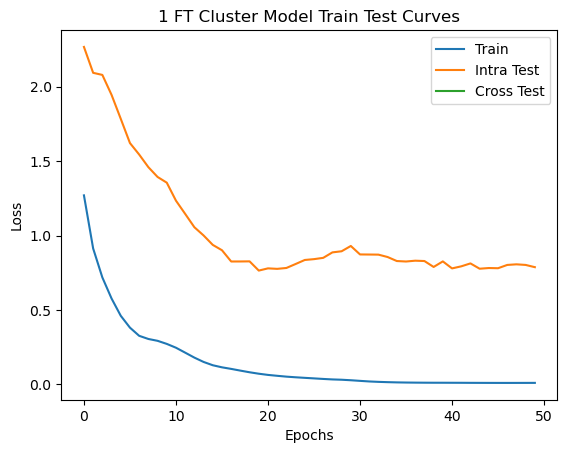

In [29]:
res_dict = {"train_loss_log": train_loss_log, "intra_test_loss_log":test_loss_log, "cross_test_loss_log":[]}
plot_train_test_curves(res_dict, "1 FT Cluster Model Train Test Curves", print_acc=False, acc_keys=None, log_keys=None)

In [30]:
print("FT_LOADER\n")

inputs, labels = next(iter(ft_loader))
print(f"Inputs shape: {inputs.shape}")
print(f"Labels shape: {labels.shape}")
num_batches = len(ft_loader)  # Only works if dataset size is known
print(f"Number of batches: {num_batches}")
batch_size = inputs.shape[0]  # First dimension is batch size
print(f"Batch size: {batch_size}")
for i, (inputs, labels) in enumerate(ft_loader):
    print(f"Batch {i+1}: Input shape {inputs.shape}, Label shape {labels.shape}")


FT_LOADER

Inputs shape: torch.Size([10, 80])
Labels shape: torch.Size([10])
Number of batches: 1
Batch size: 10
Batch 1: Input shape torch.Size([10, 80]), Label shape torch.Size([10])


In [31]:
print("INTRA_LOADER\n")

inputs, labels = next(iter(intra_test_loader))
print(f"Inputs shape: {inputs.shape}")
print(f"Labels shape: {labels.shape}")
num_batches = len(intra_test_loader)  # Only works if dataset size is known
print(f"Number of batches: {num_batches}")
batch_size = inputs.shape[0]  # First dimension is batch size
print(f"Batch size: {batch_size}")
for i, (inputs, labels) in enumerate(intra_test_loader):
    print(f"Batch {i+1}: Input shape {inputs.shape}, Label shape {labels.shape}")

INTRA_LOADER

Inputs shape: torch.Size([32, 80])
Labels shape: torch.Size([32])
Number of batches: 3
Batch size: 32
Batch 1: Input shape torch.Size([32, 80]), Label shape torch.Size([32])
Batch 2: Input shape torch.Size([32, 80]), Label shape torch.Size([32])
Batch 3: Input shape torch.Size([26, 80]), Label shape torch.Size([26])


In [32]:
local_acc_data = [] 
pretrained_acc_data = [] 
ft_acc_data = [] 
generic_acc_data = []
# Collecting data from the dictionary 
for pid in novel_pid_res_dict: 
    local_acc_data.append(novel_pid_res_dict[pid]['local_acc']) 
    pretrained_acc_data.append(novel_pid_res_dict[pid]['pretrained_acc']) 
    ft_acc_data.append(novel_pid_res_dict[pid]['ft_acc']) 
    generic_acc_data.append(novel_pid_res_dict[pid]['generic_acc']) 

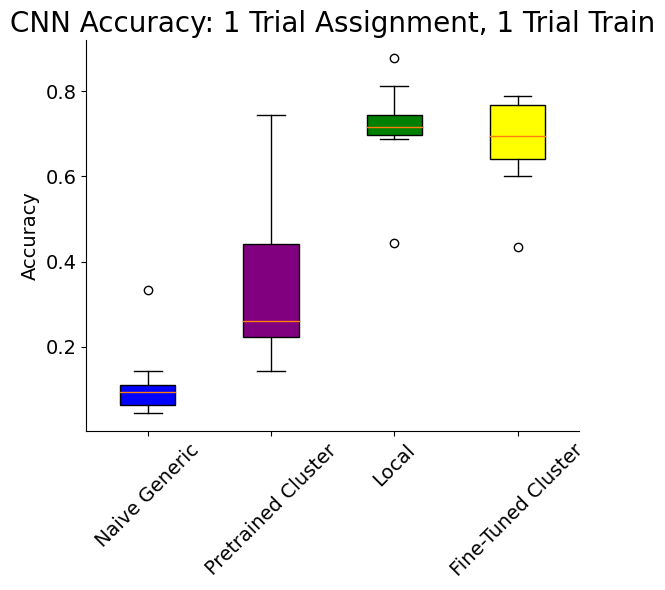

In [33]:
# Plotting box plots with improved aesthetics 
fig, ax = plt.subplots(figsize=(6, 6)) 
data = [generic_acc_data, pretrained_acc_data, local_acc_data, ft_acc_data] 
colors = ['blue', 'purple', 'green', 'yellow']
bp = ax.boxplot(data, patch_artist=True, labels=['Naive Generic', 'Pretrained Cluster', 'Local', 'Fine-Tuned Cluster']) 
# Customize boxplot colors 
for patch, color in zip(bp['boxes'], colors): 
    patch.set_facecolor(color) 
# Remove top and right borders 
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 
# Increase font sizes 
ax.set_ylabel('Accuracy', fontsize=14) 
ax.set_title('CNN Accuracy: 1 Trial Assignment, 1 Trial Train', fontsize=20) 
ax.tick_params(axis='both', labelsize=14) 
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig(f"C:\\Users\\kdmen\\Repos\\fl-gestures\\ELEC573_Proj\\results\\Final_CNN_Acc_1TA_1TT.png", dpi=500, bbox_inches='tight') 
plt.show()